<img src="media/Cryo+ESA_Logo_plain-50gray.svg" alt="CCI Cryosphere banner" width="1000"/>

# Greenland mass change exercise

The Gravity Recovery and Climate Experiment (GRACE, and it's follow-on GRACE-FO), [have the unique ability to 'weigh' the ice sheets from space](https://earth.esa.int/eogateway/missions/grace). The satellite mission uses the principle that satellite orbits are affected by gravitational changes of the Earth. In reversal, a very accurate tracking of the satellite orbits over time allows the determination of mass changes on the Earth.

In this exercise we download and visualize a GRACE CCI product of ice mass change using cate software. After the exercise you'll have an idea of the current imbalance of the Greenland icesheet and see where the icesheet is losing mass.

## Preparations
If you haven't done so please follow the [Cate tutorial](futurelearn.com/tbd) to get started using the exercises.


In [1]:
#Load some python modules to make them accessible to the notebook
from cate.core.ds import DATA_STORE_REGISTRY
from cate.util.monitor import ConsoleMonitor

#temporary hack to work around (https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop)
import nest_asyncio
nest_asyncio.apply()
# and temporary hack

monitor=ConsoleMonitor()

In [2]:
data_store = DATA_STORE_REGISTRY.get_data_store('esa_cci_odp_os')

In [ ]:
# lets query the dataserver
icesheetqry=data_store.query(query_expr="GRACE")
for it in icesheetqry:
    print(it.id)

In [4]:
# open the GRACE Greenland dataset
greenqry=data_store.query("esacci.ICESHEETS.yr.Unspecified.GMB.GRACE-instrument.GRACE.UNSPECIFIED.1-4.greenland_gmb_mass_trends")[0]

greenTrnd=greenqry.open_dataset()

## Create a scatter pot of the mass trends

Text(0.5, 1.0, 'mm/yr (equivalent water) 2003 - 2007')

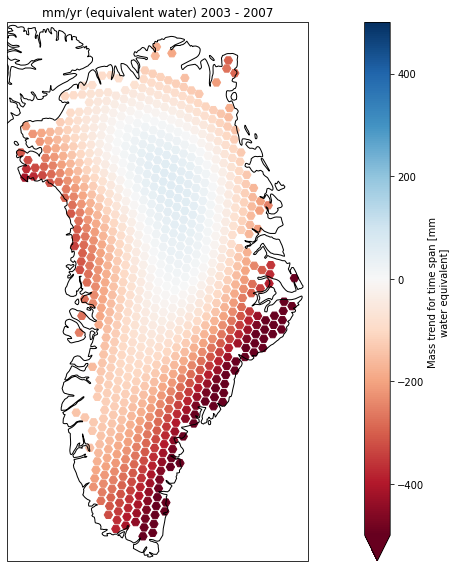

In [12]:
from xarray.plot import scatter
import cartopy.crs as ccrs
import matplotlib.pyplot as mpl
import pandas as pd
import numpy as np

%matplotlib inline
itime=0
yrstart=np.datetime_as_string(greenTrnd.start_time[itime],unit="Y")
yrend=np.datetime_as_string(greenTrnd.end_time[itime],unit="Y")
mpl.figure(figsize=(16,8))
crs=ccrs.NorthPolarStereo(-45)
xy=crs.transform_points(ccrs.PlateCarree(),greenTrnd.longitude.values,greenTrnd.latitude.values)
ax = mpl.subplot(projection=crs)
ax.coastlines()
greenTrnd.isel(time=itime).plot.scatter(x="longitude",y="latitude",hue="GMB_trend",cmap="RdBu",transform=ccrs.PlateCarree(),ax=ax,vmin=-500,vmax=500,s=70,marker='H')
ax.set_title("mm/yr (equivalent water) %s - %s"%(yrstart,yrend))

## Questions
* Try to select different trend periods (variable `itime`). In which regions do you see changes?
* To better visualize the areas which have undergone change, adapt (or copy) the code and plot the difference between two trend periods.
* The spatial resolution of mass changes from GRACE and GRACE-FO are much coarser than what can be obtained from for example ice altimetry from e.g. Cryosat-2, but there are advantages too. Try to make a list of advantages/disadvantages of gravimetry versus altimetry and exchange your findings ont he forum.
